In [ ]:
# Import necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224  # Adjusted based on common image sizes, you may need to experiment
CHANNELS = 3
EPOCHS = 50

In [ ]:
train_data_dir = r'/content/drive/MyDrive/Colab Notebooks/pcb project/Total_Dataset/Total_Dataset'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1423 files belonging to 9 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Burnt',
 'Missing Components',
 'Missing_hole',
 'Mouse_bite',
 'Open_circuit',
 'Short',
 'Spur',
 'Spurious_copper',
 'other _component']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[8 3 7 3 4 4 3 8 2 7 8 8 8 8 8 7 8 4 8 2 8 8 8 3 8 5 8 8 1 8 4 0]


In [ ]:
#Visualize Images From the Dataset

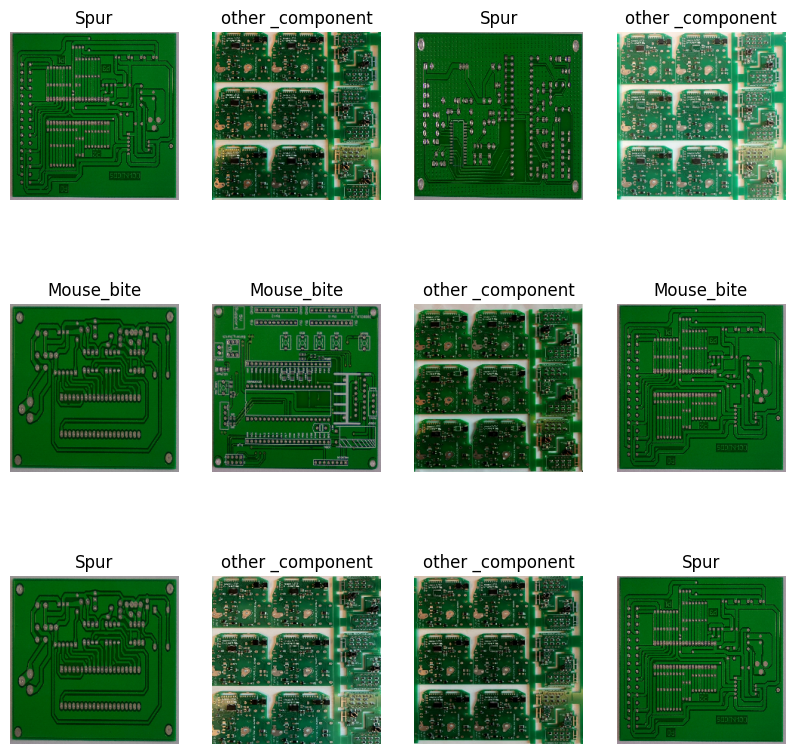

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

45

In [ ]:
train_size = 0.8
len(dataset)*train_size

36.0

In [ ]:
train_ds = dataset.take(22)
len(train_ds)

22

In [ ]:
test_ds = dataset.skip(22)
len(test_ds)

23

In [ ]:
val_size=0.1
len(dataset)*val_size

4.5

In [ ]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [ ]:
test_ds = test_ds.skip(2)
len(test_ds)

3

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)

36

In [ ]:
len(val_ds)

4

In [ ]:
len(test_ds)

5

In [ ]:
#Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Building the Model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
#Model Architecture

In [ ]:
from tensorflow.keras import layers, models

# Assuming BATCH_SIZE, IMAGE_SIZE, and CHANNELS are defined

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='tanh'),  # Use tanh activation
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='elu'),  # Use ELU activation
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='selu'),  # Use SELU activation
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='softplus'),  # Use Softplus activation
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='swish'),  # Use Swish activation
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [ ]:
unique_labels = set()
for _, labels_batch in dataset:
    unique_labels.update(labels_batch.numpy())

print("Unique Label Values:", unique_labels)


Unique Label Values: {0, 1, 2, 3, 4, 5, 6, 7, 8}


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # You can also use 'val_accuracy' depending on your preference
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,          # Lower bound on the learning rate
    verbose=1             # Print messages about learning rate reductions
)

In [ ]:
#Compiling the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

# Your code here
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50
36/36 [==============================] - 76s 1s/step - loss: 1.5122 - accuracy: 0.4714 - val_loss: 1.3197 - val_accuracy: 0.4766
Epoch 2/50
36/36 [==============================] - 9s 238ms/step - loss: 1.2175 - accuracy: 0.5084 - val_loss: 1.1487 - val_accuracy: 0.5078
Epoch 3/50
36/36 [==============================] - 7s 201ms/step - loss: 1.1308 - accuracy: 0.5137 - val_loss: 1.0570 - val_accuracy: 0.5391
Epoch 4/50
36/36 [==============================] - 9s 242ms/step - loss: 1.0408 - accuracy: 0.5304 - val_loss: 0.9772 - val_accuracy: 0.5391
Epoch 5/50
36/36 [==============================] - 8s 218ms/step - loss: 0.9959 - accuracy: 0.5374 - val_loss: 0.9375 - val_accuracy: 0.5547
Epoch 6/50
36/36 [==============================] - 7s 203ms/step - loss: 0.9701 - accuracy: 0.5383 - val_loss: 0.9419 - val_accuracy: 0.5391
Epoch 7/50
36/36 [==============================] - 8s 220ms/step - loss: 0.9568 - accuracy: 0.5471 - val_loss: 0.9773 - val_accuracy: 0.5781
Epoch 8/

In [ ]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 31s 24ms/step - loss: 0.9765 - accuracy: 0.5000


In [ ]:
# Assuming `model` is your Keras model and `test_ds` is your test dataset
model.summary()  # Check the model summary to verify the output shape

# Print out shapes for debugging
for batch in test_ds:
    features, labels = batch  # Assuming your test dataset yields features and labels
    print("Model Output Shape:", model.predict(features).shape)
    print("Labels Shape:", labels.shape)
    break  # Break after printing the first batch for inspection


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)       

In [ ]:
scores

[0.9764500856399536, 0.5]

In [ ]:
#Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 36}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.5121947526931763,
 1.217470407485962,
 1.1308026313781738,
 1.0408214330673218,
 0.9958641529083252]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

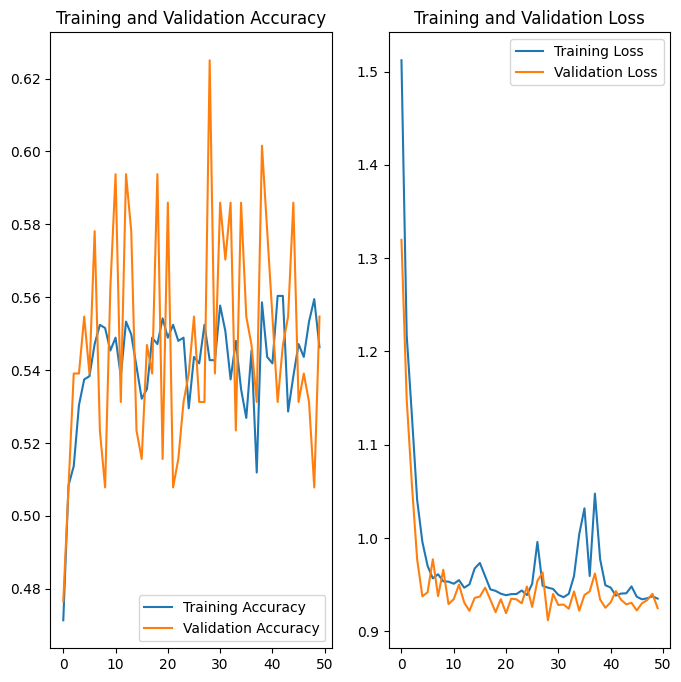

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Run prediction on a sample image

first image to predict
actual label: other _component
1/1 [==============================] - 0s 27ms/step
predicted label: other _component


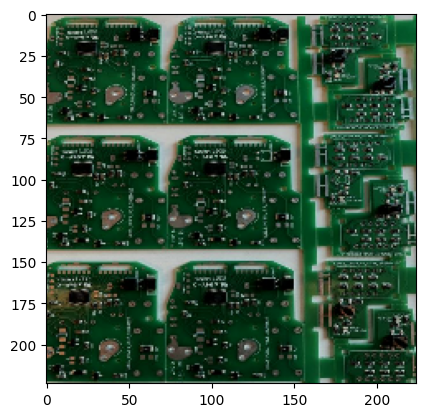

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
#Now run inference on few sample images

1/1 [==============================] - 0s 17ms/step


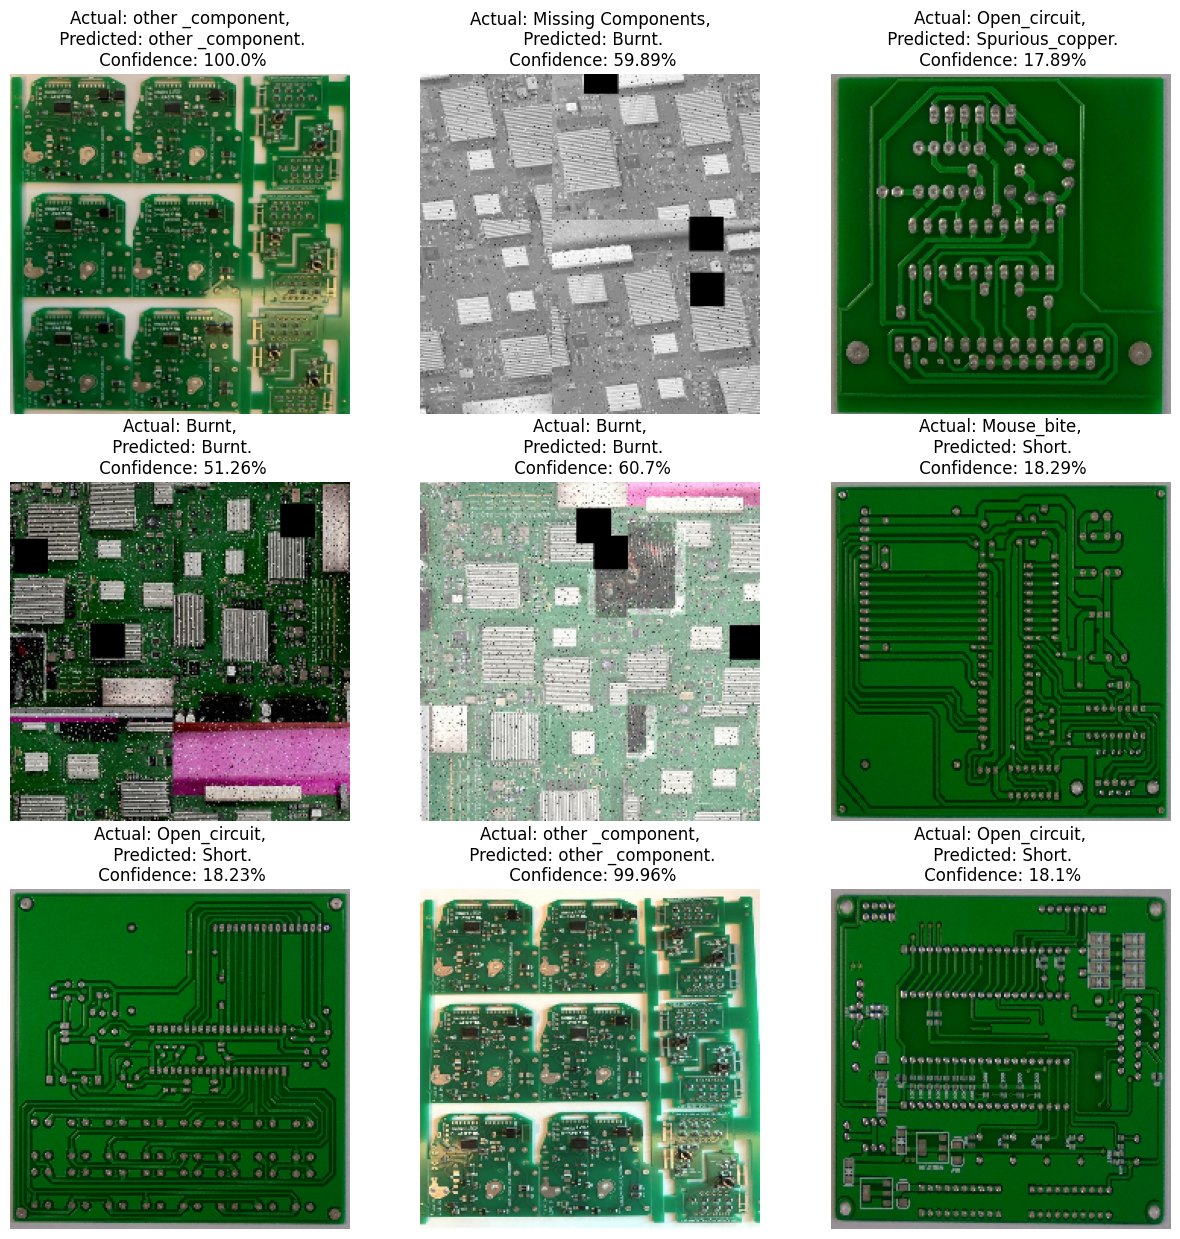

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
#Saving the Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with 10 classes (one for each type of defect)
predictions = Dense(10, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (so they don't get trained)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50


ValueError: ignored

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")